# French Electric Mix in 2019

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
%matplotlib inline 
plt.style.use('ggplot')

* https://opendata.reseaux-energies.fr/pages/accueil/
* https://bilan-electrique-2019.rte-france.com/
* https://transparency.entsoe.eu/

# Module construction production & demande 

> Données entrée : 
* Courbe de demande 
* Courbe de production 
* Capacité installée de chaque filière
* Demande nette fournit imports/exports





# Reconstruire la courbe 

In [2]:
hours = [i for i in range(24)]

"Nucléaire, renouvelable, thermique"
c0 = 40
c1 = 20
c2 = 10

In [7]:
demande = [50,45,40,40,40,40,40,40,40,45,50,55,60,60,60,70,70,70,65,60,57,53,50,50]
capacity = [30,20,10,5]

calculer ce qu'il faut combler, prendre à chaque heure, division euclidienne de la valeur


In [53]:
def dispatch(demande, capacity):
    capacity.sort(reverse=True)
# Il faut d'abord créer le dispatch, pour cela on utilise une matrice afin de savoir quelle unité sont utilisée à quelle heure
    mat = np.zeros((len(capacity)+1,24))
    capacities = np.zeros((len(capacity)+1,24))
    for (i,d) in enumerate(demande) : 
        # For each hourly demande we need to compute which solution we are going to use
        r = d 
        j = 0
        while r!=0 and j<len(capacity) :
                if capacity[j] < r:
                    # This capacity is not sufficient to match demande
                    r = r-capacity[j]
                    mat[j][i] = 1
                else :
                    # Capacity above what we need, will only use a part of it 
                    r = 0
                    mat[j][i] = 1
                    # Means that we will export the residual energy 
                    mat[len(capacity)][i] = -1

                j+=1
        if r!=0:
            mat[len(capacity)][i] = 1
    #Ensuite on créé les vecteurs qui vont nous permettre d'afficher le dispatch
    for i in range(len(hours)):
        #### On parcourt chaque heure
        maxcap_h = 0 #Permet de savoir quelle est le niveau minimum de production pour chaque heure utile pour tracer
        for j in range(len(capacity)+1):
            if j!=len(capacity):
                if mat[j][i] !=0:
                    capacities[j][i] = sum(capacity[:j+1]) #On définit la capacité
                    maxcap_h = capacities[j][i]
                else :
                    capacities[j][i] = maxcap_h

            else : 
                if mat[j][i]!=0:
                    # Les unités de production ne sont pas suffisante, ou trop importantes, il faut importer // exporter
                    capacities[j][i] = (demande[i]-sum(capacity))
    plot_dispatch(demande,capacity,capacities,mat)
    return(mat,capacities)

## Capacity to draw

In [133]:
def plot_dispatch(demande,capacity,capacities,mat):
    hours = np.array([i for i in range(24)])
    colors = ['gray','orange','blue','green','yellow']
    plt.figure(figsize=(10,10))
    plt.plot(hours,demande,label="Demande",linewidth = 5)
    for i in range(len(capacity)):
        if i ==0:
            plt.fill_between(hours,capacities[i][:],color=colors[i],label=f'Capacité {capacity[i]}')
        else : 
            plt.fill_between(hours,capacities[i-1][:],capacities[i][:],color=colors[i],label=f'Capacité {capacity[i]}')
    # Plot import & Export
    # Export
    imp_exp = capacities[len(capacity)-1][:]
    plt.fill_between(hours,imp_exp,demande,where = imp_exp>=demande,color='pink',label=f'Export')
    #Import 
    plt.fill_between(hours,imp_exp,demande,where = demande>=imp_exp, color='cyan',label=f'Import')
    plt.title(f'Dispatch avec {len(capacity)} outils de production')
    plt.legend(loc='upper left')

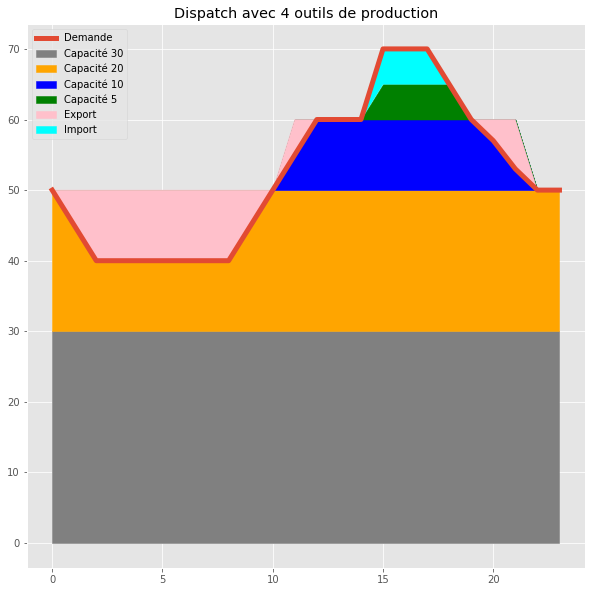

In [134]:
mat,capacities = dispatch(demande,capacity)

In [131]:
capacity2 = [25,20]

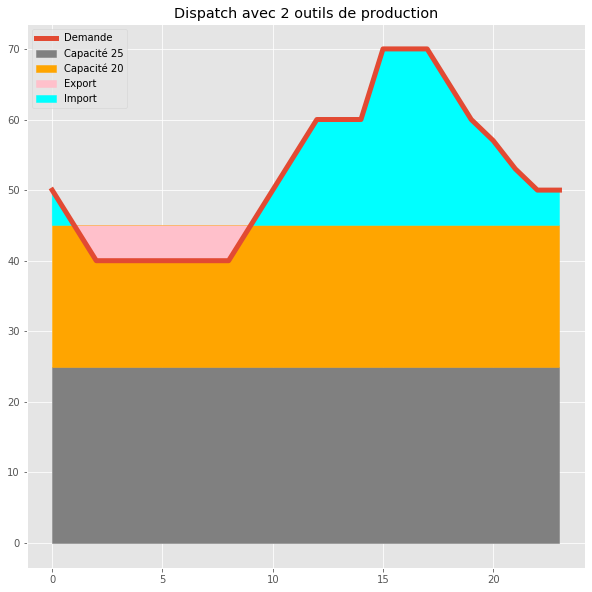

In [135]:
mat2,cap2 = dispatch(demande,capacity2)